# **CNN-DailyMail News Text Summarization**
- https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/data

## **1. 환경 설정**

### 라이브러리 import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers datasets -q

In [3]:
!pip install evaluate -q

In [4]:
!pip install rouge_score -q

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import Dataset
import evaluate

### 데이터 로드

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail/versions/2


In [8]:
os.listdir(path)

['cnn_dailymail']

In [9]:
os.listdir(os.path.join(path, 'cnn_dailymail'))

['validation.csv', 'train.csv', 'test.csv']

In [7]:
train_data = pd.read_csv(os.path.join(path, 'cnn_dailymail/train.csv'))
valid_data = pd.read_csv(os.path.join(path, 'cnn_dailymail/validation.csv'))
test_data = pd.read_csv(os.path.join(path, 'cnn_dailymail/test.csv'))

## **2. 데이터 이해**

### 데이터 구성 확인

In [11]:
train_data.shape, valid_data.shape, test_data.shape

((287113, 3), (13368, 3), (11490, 3))

In [12]:
train_data.columns, valid_data.columns, test_data.columns

(Index(['id', 'article', 'highlights'], dtype='object'),
 Index(['id', 'article', 'highlights'], dtype='object'),
 Index(['id', 'article', 'highlights'], dtype='object'))

In [13]:
print(train_data.iloc[0])
print(valid_data.iloc[0])
print(test_data.iloc[0])

id                     0001d1afc246a7964130f43ae940af6bc6c57f01
article       By . Associated Press . PUBLISHED: . 14:11 EST...
highlights    Bishop John Folda, of North Dakota, is taking ...
Name: 0, dtype: object
id                     61df4979ac5fcc2b71be46ed6fe5a46ce7f071c3
article       Sally Forrest, an actress-dancer who graced th...
highlights    Sally Forrest, an actress-dancer who graced th...
Name: 0, dtype: object
id                     92c514c913c0bdfe25341af9fd72b29db544099b
article       Ever noticed how plane seats appear to be gett...
highlights    Experts question if  packed out planes are put...
Name: 0, dtype: object


In [14]:
train_data['id'][0]

'0001d1afc246a7964130f43ae940af6bc6c57f01'

In [15]:
train_data['article'][0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [16]:
train_data['highlights'][0]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

### 데이터 길이 분포 확인

In [17]:
train_data['article_len'] = train_data['article'].apply(lambda x: len(x.split()))
train_data['highlights_len'] = train_data['highlights'].apply(lambda x: len(x.split()))

In [18]:
print(train_data['article_len'].describe())
print(train_data['highlights_len'].describe())

count    287113.000000
mean        691.869494
std         336.500035
min           8.000000
25%         443.000000
50%         632.000000
75%         877.000000
max        2347.000000
Name: article_len, dtype: float64
count    287113.000000
mean         51.574101
std          21.256336
min           4.000000
25%          38.000000
50%          48.000000
75%          60.000000
max        1296.000000
Name: highlights_len, dtype: float64


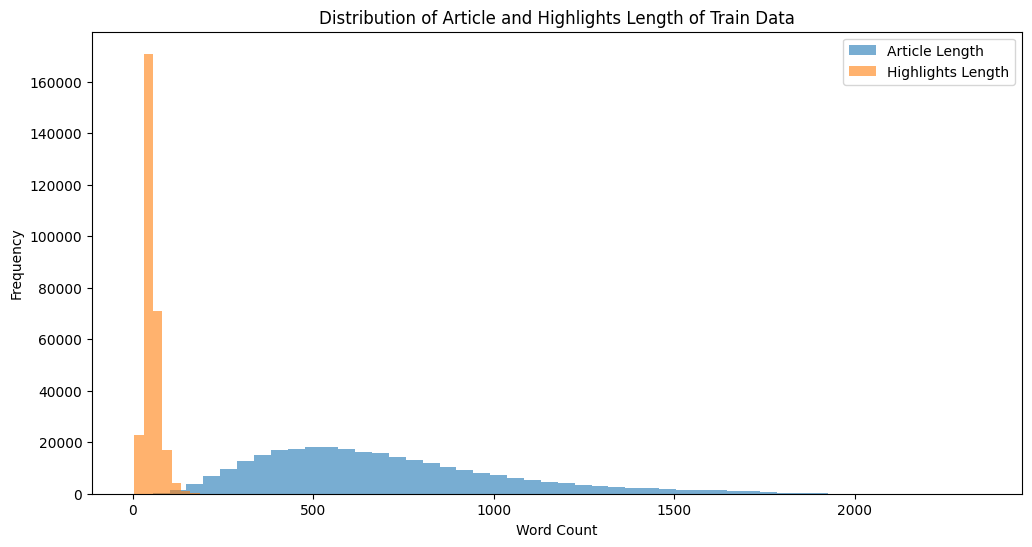

In [19]:
plt.figure(figsize=(12, 6))
plt.hist(train_data['article_len'], bins=50, alpha=0.6, label='Article Length')
plt.hist(train_data['highlights_len'], bins=50, alpha=0.6, label='Highlights Length')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Article and Highlights Length of Train Data')
plt.legend()
plt.show()

## **3-1. 모델링 (facebook/bart-base)**
- https://huggingface.co/facebook/bart-base
- 학습 시간이 비효율적으로 많이 책정되었음.
- 너무 많은 데이터 양을 원인으로 판단하여 과하게 샘플링하여 진행.

### 데이터 전처리

In [ ]:
# 데이터 양 너무 많아서 10%만 샘플링
train_data = train_data.sample(frac=0.01, random_state=42)
valid_data = valid_data.sample(frac=0.01, random_state=42)
test_data = test_data.sample(frac=0.01, random_state=42)

In [ ]:
train_data.shape, valid_data.shape, test_data.shape

((2871, 3), (134, 3), (115, 3))

In [ ]:
# 데이터셋 준비: Dataset 클래스를 활용하여 데이터 전처리 및 준비
def preprocess_function(examples):
    inputs = tokenizer(examples["article"], max_length=512, padding=True, truncation=True)
    targets = tokenizer(examples["highlights"], max_length=100, padding=True, truncation=True)
    inputs["labels"] = targets["input_ids"]
    return inputs

In [ ]:
# Hugging Face Dataset 객체로 변환
train_dataset = Dataset.from_pandas(train_data[['article', 'highlights']])
valid_dataset = Dataset.from_pandas(valid_data[['article', 'highlights']])
test_dataset = Dataset.from_pandas(test_data[['article', 'highlights']])

train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/2871 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/115 [00:00<?, ? examples/s]

### 모델 준비

In [ ]:
# 모델링: BART 로드 및 설정
model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

In [ ]:
# inputs 설정 전, max token length 확인 -> 데이터 양이 너무 많아 연산 소요 시간이 너무 길어 실행 중단.
train_data['article_token_len'] = train_data['article'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))
train_data['highlights_token_len'] = train_data['highlights'].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

KeyboardInterrupt: 

In [ ]:
print(len(tokenizer.encode(train_data['article'][772])))
print(len(tokenizer.encode(train_data['highlights'][772])))

822
48


### 학습 준비

In [ ]:
# 학습 설정
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",               # 출력 디렉토리
    evaluation_strategy="epoch",          # 매 epoch마다 평가
    learning_rate=2e-5,                   # 학습률
    per_device_train_batch_size=4,        # 배치 크기
    per_device_eval_batch_size=4,         # 평가 배치 크기
    weight_decay=0.03,                    # 가중치 감소
    save_total_limit=2,                   # 저장할 체크포인트 개수 제한
    num_train_epochs=1,                   # 에포크 수
    predict_with_generate=True,           # 텍스트 생성 활성화
    logging_dir="./logs",                 # 로깅 디렉토리
    logging_steps=10                      # 로깅 간격
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Trainer 선언
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer
)

<ipython-input-49-27e16791a172>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


### 학습

In [ ]:
# 학습 중 WANDB 에러 떠서 disabled
os.environ['WANDB_MODE'] = 'disabled'

In [ ]:
# 학습
trainer.train()

A ConfigError was raised whilst setting the number of model parameters in Weights & Biases config.


Epoch,Training Loss,Validation Loss
1,1.426400,1.434931


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=718, training_loss=2.08733276005907, metrics={'train_runtime': 305.5431, 'train_samples_per_second': 9.396, 'train_steps_per_second': 2.35, 'total_flos': 875276685803520.0, 'train_loss': 2.08733276005907, 'epoch': 1.0})

### 추론

In [ ]:
# 예측 생성
test_results = trainer.predict(test_dataset, max_length=50)
generated_summaries = tokenizer.batch_decode(test_results.predictions, skip_special_tokens=True)

In [ ]:
print('ARTICLE: ', test_data.iloc[1]['article'])
print('HIGHLIGHT: ', test_data.iloc[1]['highlights'])
print('RESULT: ', generated_summaries[1])

ARTICLE:  A woman of Arab and Jewish descent who was strip-searched at a Detroit-area airport has reached a settlement in a lawsuit filed on her behalf, the American Civil Liberties Union said Tuesday. The federal government will give Shoshana Hebshi $40,000 as compensation for being humiliated on the 10th anniversary of the 9/11 terrorist attacks after armed agents forced her from a plane at Detroit Metropolitan Airport, made her undress during a search and held her for hours. Frontier Airlines, the Transportation Security Administration and Wayne County Airport Authority were named in the federal lawsuit. Won her case: Shoshana Hebshi, of Sylvania, Ohio, who was strip-searched at a Detroit-area airport, will gain $40,000 as compensation for being humiliated . Yoga instructor: Hebshi works as a freelance writer, yoga instructor, and is a mother to two twins . Hebshi, who has a Jewish mother and Saudi Arabian father, has said she was ethnically profiled based on her dark complexion. 'I

### 평가

In [ ]:
# 평가 결과 저장
test_data['generated_summaries'] = generated_summaries
test_data[['article', 'highlights', 'generated_summaries']].to_csv("test_results.csv", index=False)

In [ ]:
# 평가 메트릭 계산 (ROUGE, BLEU 등 추가 가능)
rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=generated_summaries, references=test_data['highlights'].tolist())
print("ROUGE Scores:", rouge_scores)

ROUGE Scores: {'rouge1': 0.35777211295629896, 'rouge2': 0.15730575782752595, 'rougeL': 0.25075403362304766, 'rougeLsum': 0.3297776100430867}


## **3-2. 모델링 (t5-small)**
- https://huggingface.co/google-t5/t5-small
- 창현님 조언을 들어보니, 너무 많은 데이터 양이 아니라 무거운 모델이 원인일 수 있겠다 판단하여 모델 교체.

### 데이터 전처리

In [8]:
train_data.shape, valid_data.shape, test_data.shape

((287113, 3), (13368, 3), (11490, 3))

In [9]:
# 데이터 전처리 함수
def preprocess_function2(examples):
    inputs = tokenizer(examples["article"], max_length=512, truncation=True, padding="max_length")
    targets = tokenizer(examples["highlights"], max_length=150, truncation=True, padding="max_length")
    inputs["labels"] = targets["input_ids"]
    return inputs

In [ ]:
# Hugging Face Dataset 객체로 변환
train_dataset = Dataset.from_pandas(train_data[['article', 'highlights']])
valid_dataset = Dataset.from_pandas(valid_data[['article', 'highlights']])
test_dataset = Dataset.from_pandas(test_data[['article', 'highlights']])

train_dataset = train_dataset.map(preprocess_function2, batched=True)
valid_dataset = valid_dataset.map(preprocess_function2, batched=True)
test_dataset = test_dataset.map(preprocess_function2, batched=True)

In [ ]:
# 리소스 오류로 세션 다운.. ㅠ

### 모델 준비

In [20]:
# 모델링: t5-small 로드 및 설정
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### 학습 준비

In [ ]:
# 학습 설정
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,  # T5는 더 작은 메모리 사용 가능
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_steps=10
)

In [ ]:
# Trainer 선언
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer
)

### 학습

In [ ]:
# 모델 학습 실행
trainer.train()

### 추론

In [ ]:
# 테스트 데이터로 예측 생성
test_results = trainer.predict(test_dataset, max_length=150)
generated_summaries = tokenizer.batch_decode(test_results.predictions, skip_special_tokens=True)

In [ ]:
# 결과 확인 (테스트 데이터의 예측 출력)
print('ARTICLE: ', test_data.iloc[0]['article'])
print('HIGHLIGHT: ', test_data.iloc[0]['highlights'])
print('RESULT: ', generated_summaries[0])

### 평가

In [ ]:
# 평가 결과 저장
test_data['generated_summaries'] = generated_summaries
test_data[['article', 'highlights', 'generated_summaries']].to_csv("t5_test_results.csv", index=False)

In [ ]:
# ROUGE 평가 메트릭 계산
rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=generated_summaries, references=test_data['highlights'].tolist())
print("ROUGE Scores:", rouge_scores)